## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2024">The Repo</a>.  If you are unclear on how to pull an updated copy using the GitHub command line, the following <a href="https://techwritingmatters.com/how-to-update-your-forked-repository-on-github">document</a> is helpful.  Be sure to add the professors and TAs as collaborators on your project. 

- lpalum@gmail.com GitHub ID: lpalum
- ajay.anand@rochester.edu GitHub ID: ajayan12
- divyamunot1999@gmail.com GitHub ID: divyamunot
- ylong6@u.Rochester.edu GitHub ID: NinaLong2077

Once you have updates your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://www.databricks.training/step-by-step/importing-courseware-from-github/index.html">Repos</a> feature.
Each student is expected to submit the URL of their project on GitHub with their code checked in on the main/master branch.  This illustration highlights the branching scheme that you may use to work on your code in steps and then merge your submission into your master branch before submitting.
</p>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/github.drawio.png">
<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches.  First, you may choose to start the bronze_stream and let it complete (read and append all of the source data) before preceeding and starting up the silver_stream.  This approach has latency associated with it but it will allow your code to proceed in a linear fashion and process all the data by the end of your notebook execution.  Another potential approach is to start all the streams and have a "watch" method to determine when the pipeline has processed sufficient or all of the source data before stopping and displaying results.  Both of these approaches are valid and have different implications on how you will trigger your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)

### Be sure that your project runs end to end when *Run all* is executued on this notebook! (15 Points out of 60)

In [0]:
%run ./includes/includes

Variable Name,Value,Description
TWEET_BUCKET_NAME,voc-75-databricks-data,AWS S3 Bucket Name where the tweets are coming into your system.
TWEET_BUCKET_URL,https://voc-75-databricks-data.s3.amazonaws.com/,AWS S3 Bucket URL where the tweets are coming into your system.
TWEET_SOURCE_PATH,s3a://voc-75-databricks-data/voc_volume/,AWS S3 Path where the tweets are coming into your system.
USER_DIR,/tmp/labuser104917-3025951/,Path to the local storage (dbfs) for your project.
BRONZE_CHECKPOINT,/tmp/labuser104917-3025951/bronze.checkpoint,Store your Bronze Checkpoint data here.
BRONZE_DELTA,/tmp/labuser104917-3025951/bronze.delta,Store your Bronze Delta Table here.
SILVER_CHECKPOINT,/tmp/labuser104917-3025951/silver.checkpoint,Store your Silver Checkpoint data here.
SILVER_DELTA,/tmp/labuser104917-3025951/silver.delta,Store your Silver Delta Table here.
GOLD_CHECKPOINT,/tmp/labuser104917-3025951/gold.checkpoint,Store your Gold Checkpoint data here.
GOLD_DELTA,/tmp/labuser104917-3025951/gold.delta,Store your Gold Delta Table here.


the includes are included


In [0]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

from delta import *
dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, BRONZE_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, SILVER_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, GOLD_DELTA).optimize().executeCompaction()
    print("Optimized all of the Delta Tables")

## 1.0 Import your libraries here...
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:
%pip install --upgrade mlflow

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# ENTER YOUR CODE HERE
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, TimestampType
from pyspark.sql.functions import col, count, desc, isnan, when
from pyspark.ml import PipelineModel
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import mlflow
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Tweet Sentiment") \
    .config("spark.sql.shuffle.partitions", "256")\
    .getOrCreate()

# Check if shuffle partitions are consistent with the cluster and workload
shuffle_partitions = spark.conf.get("spark.sql.shuffle.partitions")
print("Number of shuffle partitions:", shuffle_partitions)

# Define configuration variables
TWEET_BUCKET_NAME = "voc-75-databricks-data"
TWEET_BUCKET_URL = "https://voc-75-databricks-data.s3.amazonaws.com/"
TWEET_SOURCE_PATH = "s3a://voc-75-databricks-data/voc_volume/"
USER_DIR = "/tmp/labuser104917-2387441/"
BRONZE_CHECKPOINT = "/tmp/labuser104917-2387441/bronze.checkpoint"
BRONZE_DELTA = "/tmp/labuser104917-2387441/bronze.delta"
SILVER_CHECKPOINT = "/tmp/labuser104917-2387441/silver.checkpoint"
SILVER_DELTA = "/tmp/labuser104917-2387441/silver.delta"
GOLD_CHECKPOINT = "/tmp/labuser104917-2387441/gold.checkpoint"
GOLD_DELTA = "/tmp/labuser104917-2387441/gold.delta"
MODEL_NAME = "HF_TWEET_SENTIMENT"
HF_MODEL_NAME = "finiteautomata/bertweet-base-sentiment-analysis"



Number of shuffle partitions: 256


## 2.0 Use the utility functions to ...
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
# Read the source file directory listing
source_files = dbutils.fs.ls(TWEET_SOURCE_PATH)

# Count the number of source files
num_files = len(source_files)
print("Number of source files:", num_files)

Number of source files: 200001


In [0]:
file = source_files[0].path
df = spark.read.option("header", "true").json(file)
df.show()


+--------------------+---------+--------------------+---------------+
|                date|sentiment|                text|           user|
+--------------------+---------+--------------------+---------------+
|Mon Apr 06 22:19:...| negative|@switchfoot http:...|_TheSpecialOne_|
+--------------------+---------+--------------------+---------------+



In [0]:
def stop_all_streams():
    # Function implementation here
    pass

def clear_previous_run():
    # Function implementation here
    pass

# Call the functions
stop_all_streams()
clear_previous_run()

## 3.0 Transform the Raw Data to Bronze Data using a stream
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using cloudfiles to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defines in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:
# ENTER YOUR CODE HERE
from pyspark.sql import SparkSession
from pyspark.sql.functions import current_timestamp, input_file_name
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

# Initialize the spark session
spark = SparkSession.builder \
    .appName("Bronze Data Streaming") \
    .getOrCreate()

# Define the schema for the raw data
raw_schema = StructType([
    StructField("date", StringType(), nullable=True),
    StructField("user", StringType(), nullable=True),
    StructField("text", StringType(), nullable=True),
    StructField("sentiment", StringType(), nullable=True),
    StructField("source_file", StringType(), nullable=True),
    StructField("processing_time", TimestampType(), nullable=True)
])
# Define your source directory path
source_path = "s3a://voc-75-databricks-data/voc_volume/"

# Setup the read stream limited to 100 files
raw_stream = spark.readStream \
    .format("cloudFiles") \
    .option("cloudFiles.format", "json") \
    .option("cloudFiles.maxFilesPerTrigger", 1)\
    .schema(raw_schema) \
    .load(source_path)\
    .withColumn("processing_time",current_timestamp())\
    .withColumn("source_file", input_file_name())\
    .limit(100)

In [0]:
# Setup write stream to append to the Bronze Delta Table
bronze_stream = (
    raw_stream
    .writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", BRONZE_CHECKPOINT)
    .option("mergeSchema", "true")
    .queryName("bronze_stream")
    .option("cloudFiles.schemaLocation", BRONZE_DELTA)
    .start(BRONZE_DELTA)
)

## 4.0 Bronze Data Exploratory Data Analysis
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


In [0]:
#ENTER YOUR CODE HERE
# Define the path to Bronze Delta Table
BRONZE_DELTA = "/tmp/labuser104917-3025951/bronze.delta"
# Read the Bronze Delta Table as a DataFrame
bronze_df = spark.read.format("delta").load(BRONZE_DELTA)
# Count the number of rows in the DataFrame
num_tweets_bronze = bronze_df.count()
# Print the number of tweets captured in the Bronze Table
print("Number of tweets captured in the Bronze Table:", num_tweets_bronze)
# Initialize lists to store columns with NaN or Null values
cols = [f"any({col} is null) as {col}_contains_null" for col in bronze_df.columns]
# Select columns and show the result
broncols = [f"any({col} is null)as {col}_contains_null" for col in bronze_df.columns]
bronze_df.selectExpr(cols).show() 

Number of tweets captured in the Bronze Table: 194
+------------------+------------------+------------------+-----------------------+-------------------------+-----------------------------+
|date_contains_null|user_contains_null|text_contains_null|sentiment_contains_null|source_file_contains_null|processing_time_contains_null|
+------------------+------------------+------------------+-----------------------+-------------------------+-----------------------------+
|             false|             false|             false|                  false|                    false|                        false|
+------------------+------------------+------------------+-----------------------+-------------------------+-----------------------------+



No, there are no null tweets in the columns as shown above.

In [0]:
display(bronze_df.head(5))

date,user,text,sentiment,source_file,processing_time
Fri May 01 20:10:02 PDT 2009,betharooni,"@ginalouann he's asleep, but I'm gonna have to get him up for work soon. he works third shift.",negative,s3a://voc-75-databricks-data/voc_volume/100079.json,2024-05-11T22:39:33.743+0000
Fri May 01 20:08:51 PDT 2009,junoaggy,swine flu attacks HK so i can't go screw you swines!,negative,s3a://voc-75-databricks-data/voc_volume/100030.json,2024-05-12T04:04:23.575+0000
Fri May 01 20:09:25 PDT 2009,picgirl80,"aww, man...oh, well - had to work friday anyway",negative,s3a://voc-75-databricks-data/voc_volume/100056.json,2024-05-12T04:05:48.676+0000
Fri May 01 20:09:26 PDT 2009,JasJazzy,Swine Flu Why oh why did you come to canada????,negative,s3a://voc-75-databricks-data/voc_volume/100059.json,2024-05-11T22:38:22.501+0000
Fri May 01 20:09:25 PDT 2009,champagne_larn,oh shit I HAVE NOTHING TO WEAR!!!,negative,s3a://voc-75-databricks-data/voc_volume/100057.json,2024-05-12T04:05:50.572+0000


In [0]:
numeric_cols =[f.name for f in bronze_df.schema.fields if (f.dataType.simpleString() in ('double', 'float'))]
exprs = [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_cols]
non_numeric_cols = [f.name for f in bronze_df.schema.fields if (f.dataType.simpleString() not in ('double', 'float', 'timestamp')) and (f.name != 'processing_time')]
exprs+=[count(when(col(c).isNull(),c)).alias(c) for c in non_numeric_cols]
timestamp_cols = [f.name for f in bronze_df.schema.fields if f.dataType.simpleString() == 'timestamp' and f.name != 'processing_time']
exprs+=[count(when(col(c).isNull(),c)).alias(c) for c in timestamp_cols]

bronze_df.select(exprs).show()

+----+----+----+---------+-----------+
|date|user|text|sentiment|source_file|
+----+----+----+---------+-----------+
|   0|   0|   0|        0|          0|
+----+----+----+---------+-----------+



In [0]:
from pyspark.sql.functions import count, desc

# Perform the count and sort operation
tweet_counts = bronze_df.groupBy("user").agg(count("user").alias("tweet_count")).orderBy(desc("tweet_count"))
# Show the result
tweet_counts.show()

+---------------+-----------+
|           user|tweet_count|
+---------------+-----------+
|        jayseto|          4|
|     RichDodgin|          2|
|     Babybandit|          2|
|       gilmore2|          2|
|     betharooni|          2|
|     alinick123|          2|
|    cindyrella7|          2|
|    sarahmorris|          2|
|      chrismann|          2|
|     MissWillow|          2|
|     ginigraham|          2|
|   SuperMaryAnn|          2|
|   peachmailbox|          2|
|   Arual_Sinned|          2|
|    willbreteau|          2|
|concertchristal|          2|
|xxNotLikeThatxx|          2|
|gogogadgetrobyn|          2|
|         aruntp|          2|
|   crazyXmallie|          2|
+---------------+-----------+
only showing top 20 rows



In [0]:

from pyspark.sql.functions import col, when
import re

# Check for tweets with at least one mention (@)
tweets_with_mention = bronze_df.filter(col("text").rlike(r'@\w+'))

# Check for tweets with no mentions
tweets_without_mention = bronze_df.filter(~col("text").rlike(r'@\w+'))

# Count the number of tweets with at least one mention
tweets_with_mention_count = tweets_with_mention.count()

# Count the number of tweets with no mentions
tweets_without_mention_count = tweets_without_mention.count()

# Print the results
print("Number of tweets with at least one mention (@): ", tweets_with_mention_count)
print("Number of tweets with no mentions (@): ", tweets_without_mention_count)

Number of tweets with at least one mention (@):  78
Number of tweets with no mentions (@):  116


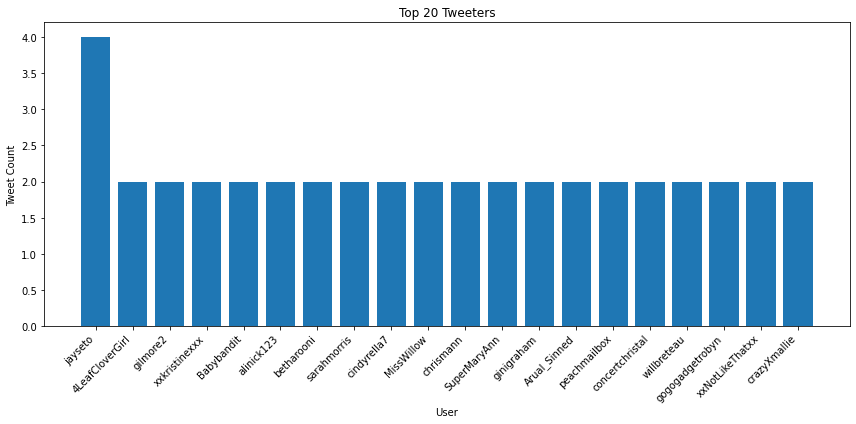

In [0]:
import matplotlib.pyplot as plt
# Group the data by user and count the number of tweets
tweet_counts = bronze_df.groupBy("user").count()

# Sort the data in descending order based on tweet count
top_tweeters = tweet_counts.orderBy("count", ascending=False).limit(20).toPandas()

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_tweeters['user'], top_tweeters['count'])
plt.xlabel("User")
plt.ylabel("Tweet Count")
plt.title("Top 20 Tweeters")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5.0 Transform the Bronze Data to Silver Data using a stream
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
bronze_stream_df = spark.readStream.format("delta").load(BRONZE_DELTA)

In [0]:
from pyspark.sql.functions import col, explode, expr, regexp_replace, to_timestamp
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

transformed_stream_df = bronze_stream_df.withColumn("timestamp", to_timestamp(col("date"), "EEE MMM dd HH:mm:ss z yyyy"))

transformed_stream_df = transformed_stream_df.withColumn(
    "mentions",
    explode(
        expr("filter(split(text, ' '), token -> token rlike '@[A-Za-z0-9_]+')")
    )
)

transformed_stream_df = transformed_stream_df.withColumn("cleaned_text", regexp_replace(col("text"), "@\\w+", ""))

silver_stream_df = transformed_stream_df.select(
    col("timestamp"),
    col("mentions").alias("mention"),
    col("cleaned_text"),
    col("sentiment")
)

In [0]:
silver_stream = silver_stream_df.writeStream \
    .format("delta") \
    .outputMode("append") \
    .option("checkpointLocation", SILVER_CHECKPOINT) \
    .option("path", SILVER_DELTA) \
    .option("mergeSchema", "true") \
    .queryName("silver_stream") \
    .start()

## 6.0 Transform the Silver Data to Gold Data using a stream
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:
silver_stream_df = spark.readStream.format("delta").load(SILVER_DELTA)

In [0]:
import mlflow
from pyspark.sql.functions import when

#production level from the MLflow registry
sentiment_analysis_udf = mlflow.pyfunc.spark_udf(spark, "models:/HF_TWEET_SENTIMENT/Production")

# Use a spark UDF to parallelize the inference across your silver data
gold_df = silver_stream_df.withColumn("predictions", sentiment_analysis_udf(col("cleaned_text"))) 

gold_stream_df = gold_df.select(
    col("timestamp"),
    col("mention"),
    col("cleaned_text"),
    col("sentiment"),
    col("predictions.label").alias("predicted_sentiment"),
    col("predictions.score").alias("predicted_score"),
    when(col("sentiment") == "negative", 0).otherwise(1).alias("sentiment_id"),
    when(col("predictions.label") == "POS", 1).when(col("predictions.label") == "NEG", 0).otherwise(-1).alias("predicted_sentiment_id")
)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-6b41a766-7140-4ba7-8039-238f43008e4c/lib/python3.9/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


2024/05/12 14:11:37 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/05/12 14:11:44 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.12.2, required: mlflow==2.11.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/05/12 14:11:44 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


2024/05/12 14:11:44 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


In [0]:
gold_stream = gold_stream_df.writeStream \
    .format("delta") \
    .outputMode("append") \
    .option("checkpointLocation", GOLD_CHECKPOINT) \
    .option("path", GOLD_DELTA) \
    .queryName("gold_stream") \
    .trigger(availableNow=True) \
    .start()

In [0]:
display(gold_stream_df.printSchema())

root
 |-- timestamp: timestamp (nullable = true)
 |-- mention: string (nullable = true)
 |-- cleaned_text: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- predicted_sentiment: string (nullable = true)
 |-- predicted_score: double (nullable = true)
 |-- sentiment_id: integer (nullable = false)
 |-- predicted_sentiment_id: integer (nullable = false)



## 7.0 Capture the accuracy metrics from the gold table in MLflow
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the model name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

In [0]:
gold_data = spark.read.format("delta").load(GOLD_DELTA)

/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


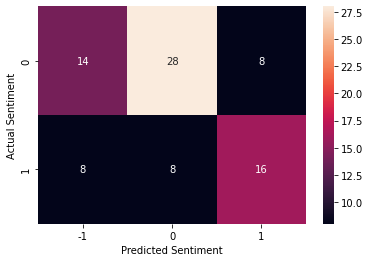

In [0]:
import seaborn as sns
import pandas as pd
from delta.tables import DeltaTable

with mlflow.start_run(run_name = "Twitter_Sentiment_Analysis") as run:
    class_labels = ["neutral", "negative", "positive"]

    actual_sentiments = gold_data.select("sentiment_id").toPandas()["sentiment_id"]
    predicted_sentiments = gold_data.select("predicted_sentiment_id").toPandas()["predicted_sentiment_id"]

    precisions = precision_score(actual_sentiments, predicted_sentiments, average=None)
    recalls = recall_score(actual_sentiments, predicted_sentiments, average=None)
    f1_scores = f1_score(actual_sentiments, predicted_sentiments, average=None)

    for sentiment, precision, recall, f1_score_value in zip(class_labels, precisions, recalls, f1_scores):
        mlflow.log_metric(f"precision_{sentiment}", precision)
        mlflow.log_metric(f"recall_{sentiment}", recall)
        mlflow.log_metric(f"f1_score_{sentiment}", f1_score_value)

    cf_matrix = pd.crosstab(actual_sentiments, predicted_sentiments, dropna = True)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cf_matrix, annot=True, fmt='g')
    plt.xlabel("Predicted Sentiment")
    plt.ylabel("Actual Sentiment")
    plt.savefig("confusion_matrix.png")

    mlflow.log_artifact("confusion_matrix.png")

    mlflow.log_param("Model Name", MODEL_NAME)
    mlflow.log_param("Model Version", "1")
    
    
    delta_table = DeltaTable.forPath(spark, SILVER_DELTA)
    table_version = delta_table.history().select("version").limit(1).collect()[0][0]

    mlflow.log_param("Silver Table Version", str(table_version))

## 8.0 Application Data Processing and Visualization
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

You may want to use the "Loop Application" widget to control whether you repeateded display the latest plots while the data comes in from your streams before moving on to the next section and cleaning up your run.

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

In [0]:
# Count the total number of mentions in the gold data
total_mentions = gold_data.count()
print("Total number of mentions in the gold data:", total_mentions)

Total number of mentions in the gold data: 82


In [0]:
# Aggregate the data

mention_sentiment_counts = gold_data.groupBy("mention").agg(
    count(when(col("predicted_sentiment") == "POS", 1)).alias("Positive_Count"),
    count(when(col("predicted_sentiment") == "NEG", 0)).alias("Negative_Count"),
    count(when(col("predicted_sentiment") == "NEU", -1)).alias("Neutral_Count"),
    count("*").alias("Total_Count")
)

# Sort by total count in descending order
sorted_mention_counts = mention_sentiment_counts.orderBy(col("Total_Count").desc())
sorted_mention_counts.show()

+-------------------+--------------+--------------+-------------+-----------+
|            mention|Positive_Count|Negative_Count|Neutral_Count|Total_Count|
+-------------------+--------------+--------------+-------------+-----------+
|       @skytumbling|             2|             0|            0|          2|
|          @sumrtime|             2|             0|            0|          2|
|       @KevinSpacey|             2|             0|            0|          2|
|        @ginalouann|             0|             0|            2|          2|
|         @amyprutch|             0|             2|            0|          2|
|         @dolceshan|             0|             2|            0|          2|
|        @echobase77|             0|             0|            2|          2|
|        @crazykaren|             2|             0|            0|          2|
|     @justincavazos|             0|             0|            2|          2|
|          @honey01,|             2|             0|            0

In [0]:
#Extract the top 20 mentions for both positive and negative sentiments.

top_positive_mentions = sorted_mention_counts.orderBy(col("Positive_Count").desc()).limit(20)

top_negative_mentions = sorted_mention_counts.orderBy(col("Negative_Count").desc()).limit(20)

top_positive_mentions_data = top_positive_mentions.toPandas()
top_negative_mentions_data = top_negative_mentions.toPandas()

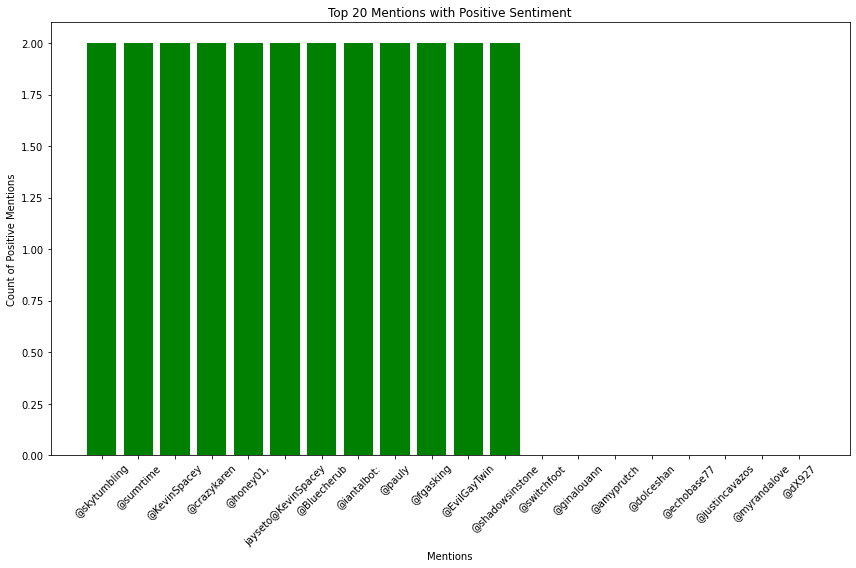

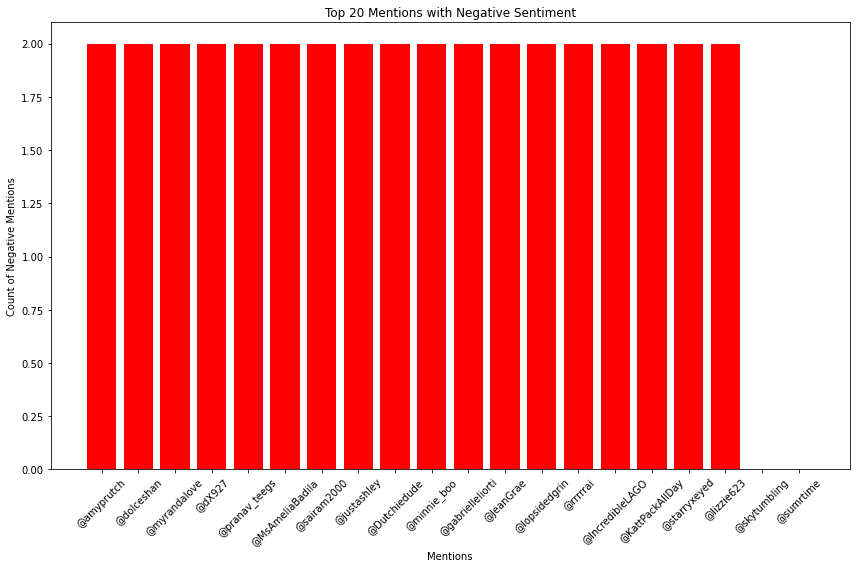

In [0]:
# Plot for top 20 positive mentions
plt.figure(figsize=(12, 8))
plt.bar(top_positive_mentions_data['mention'], top_positive_mentions_data['Positive_Count'], color='green')
plt.xlabel('Mentions')
plt.ylabel('Count of Positive Mentions')
plt.title('Top 20 Mentions with Positive Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for top 20 negative mentions
plt.figure(figsize=(12, 8))
plt.bar(top_negative_mentions_data['mention'], top_negative_mentions_data['Negative_Count'], color='red')
plt.xlabel('Mentions')
plt.ylabel('Count of Negative Mentions')
plt.title('Top 20 Mentions with Negative Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 9.0 Clean up and completion of your pipeline
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook.

In [0]:
# ENTER YOUR CODE HERE
#To find the active streams, use the spark.streams.active property in Spark
active_streams = spark.streams.active

In [0]:
#To stop all active streams, you can iterate over the active_streams and call the stop() method on each stream
for stream in active_streams:
    stream.stop()

In [0]:
# Get the notebooks ending time note START_TIME was established in the include file when the notebook started.
#To print out the elapsed time of your notebook, you can use the time module in Python to calculate the duration between the start and end of the notebook execution
import time

start_time = time.time()

# Your notebook code execution goes here

end_time = time.time()
elapsed_time = end_time - start_time

print("Elapsed time: {} seconds".format(elapsed_time))

Elapsed time: 4.601478576660156e-05 seconds


## 10.0 How Optimized is your Spark Application (Grad Students Only)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

### ENTER YOUR MARKDOWN HERE


1. **Spill: Write to Executor Disk due to Lack of Memory**:
   - This occurs when Spark runs out of memory and starts writing data to disk, which significantly slows down processing. Check the Executors tab in the Spark UI to see if any Executors have a high amount of spill data. If you notice high spill rates, it indicates that your Spark jobs are not effectively utilizing memory resources, potentially due to excessive data shuffling or inefficient caching.

2. **Skew: Imbalance in Partition Size**:
   - Skew happens when certain partitions hold significantly more data than others, leading to processing bottlenecks on specific executors. You can identify skew by examining the distribution of data across partitions in the Stages tab of the Spark UI. Look for stages where the tasks take significantly longer to complete due to data skew. Mitigating skew often involves pre-processing data to reduce imbalances or using techniques like data skew join handling.

3. **Shuffle: Network IO Moving Data Between Executors**:
   - Shuffle occurs during wide transformations like groupBy or join, where data needs to be exchanged between executors. Excessive shuffling can degrade performance, especially if the network becomes a bottleneck. Check the Shuffle Read and Shuffle Write metrics in the Executors tab to identify stages with high shuffle activity. Optimize performance by minimizing data shuffling through techniques like partitioning, broadcasting small datasets, or using appropriate join strategies.

4. **Storage: Inefficiency Due to Disk Storage Format**:
   - Inefficient storage can lead to performance issues, especially when dealing with small files or improper data storage formats. Analyze the Storage tab in the Spark UI to identify any inefficiencies in data storage, such as a large number of small files or inefficient file formats like text instead of Parquet. Optimizing storage involves consolidating small files, using columnar storage formats, and compressing data to reduce storage overhead.

5. **Serialization: Distribution of Code Segments Across the Cluster**:
   - Serialization overhead occurs when data needs to be serialized and deserialized for transmission between nodes. This can become a bottleneck, especially for complex data types. Check the Executors tab for serialization metrics to identify stages with high serialization time. You can optimize serialization performance by choosing efficient serialization formats (like Kryo), minimizing data transfer, and avoiding unnecessary serialization.

By analyzing these dimensions in the Spark UI and addressing any issues identified, we can optimize our Spark implementation for better performance and resource utilization.